In [2]:
!pip install requests_toolbelt -q
!pip install owslib -q
!pip install bs4 -q
!pip install lxml -q

In [3]:
import json
import requests
import os
from shapely.geometry import shape, box, mapping
from requests_toolbelt.multipart import decoder
import rasterio
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [247]:
def get_image_wcs_getcapabilities():
   wcs_url = 'https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?SERVICE=WCS&REQUEST=GetCapabilities'
   wcs_get = requests.get(wcs_url+'&version=1.1.1&connectid='+sw_connect_id)
   #wcs_post = requests.post(wcs_url, data=wcs_query)
   print(wcs_get)
   print(wcs_get.content)
    
def get_image_wcs_describecoverage(feature_id):
   wcs_url = 'https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?SERVICE=WCS&REQUEST=DescribeCoverage'
   wcs_get = requests.get(wcs_url+'&version=1.1.1&connectid='+sw_connect_id+'&identifiers='+feature_id)
   #wcs_post = requests.post(wcs_url, data=wcs_query)
   print(wcs_get)
   print(wcs_get.content)

def get_image_wfs_metadata(feature_id):
   wfs_url = 'https://securewatch.digitalglobe.com/catalogservice/wfsaccess?REQUEST=GetFeature&SERVICE=WFS'
   wfs_query = {
   'version':'1.0.0',
   'typeName' : 'DigitalGlobe:FinishedFeature',
   'layer': sw_data_layer,
   'srsName': 'EPSG:4326',
   'outputFormat': 'json',
   'featureId' : feature_id,
   'CONNECTID': sw_connect_id
   'CQL_Filter':leg
   }
   wfs_post = requests.post(wfs_url, data=wfs_query)
   body = json.loads(wfs_post.text)
   #convert complex geometry coverage to a BBOX
   geom = shape(body['features'][0]['geometry'])
   bbox = '{0},{1},{2},{3}'.format(geom.bounds[1], geom.bounds[0],geom.bounds[3],geom.bounds[2])
   acquisition_date = body['features'][0]['properties']['acquisitionDate']
   band_order = body['features'][0]['properties']['colorBandOrder']
   gsd = body['features'][0]['properties']['groundSampleDistance']
   crs = body['crs']['properties']['name']
   return(acquisition_date, gsd, crs, band_order, bbox)

def get_image_wcs_tiff(image_feature, image_bbox, image_crs, image_sequence):
   wcs_url = 'https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?REQUEST=GetCoverage&SERVICE=WCS'
   wcs_query = {
   'version':'1.1.1',
   'format':'image/tiff',
   'identifier': image_feature,
   'boundingBox': image_bbox+','+image_crs,
   'GridBaseCRS': image_crs,
   'GridOffsets' : '0.00010,0.00010',
   'CONNECTID': sw_connect_id#, 
   #'RangeSubset': '1,BAND'
   }
   image_file = image_sequence+'_image.tif'
   wcs_get = requests.post(wcs_url, data=wcs_query)
   print(wcs_get)
   print(wcs_get.content)
#    multi_response = decoder.MultipartDecoder.from_response(wcs_get)
#    for part in multi_response.parts:
#        print(part.headers)
#        if str(part.headers).__contains__('text/xml'):
#            continue
#        else:
#            with open(image_file, 'wb') as file:
#                file.write(part.content)

In [248]:
#https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?connectid=6225d66d-49f3-4606-858c-09d7eb33cb80
connect_id = '6225d66d-49f3-4606-858c-09d7eb33cb80'
feature_id = 'ab582b8d45817928a5feba0b0da342e9' #Venice - 6/10/18, WV03
image_1_sw_feature = '12adf703f543ca7314eb7d4f91891ac2'
image_2_sw_feature = 'f09cdf93f24eb73cf8d2d70f6763bd8b'

sw_data_layer = 'daily_take'
sw_connect_id = '75bd8489-d691-45d4-ba77-8db7efcf5565'


In [245]:
get_image_wcs_getcapabilities()

<Response [200]>
b'<?xml version="1.0" encoding="UTF-8"?><wcs:Capabilities version="1.1.1" xmlns:wcs="http://www.opengis.net/wcs/1.1.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:ogc="http://www.opengis.net/ogc" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/wcs/1.1.1 https://securewatch.digitalglobe.com/deliveryservice/schemas/wcs/1.1.1/wcsGetCapabilities.xsd" updateSequence="103"><ows:ServiceIdentification><ows:Title>DigitalGlobe Web Coverage Service</ows:Title><ows:Abstract>\n     </ows:Abstract><ows:Keywords><ows:Keyword>WCS</ows:Keyword></ows:Keywords><ows:ServiceType>WCS</ows:ServiceType><ows:ServiceTypeVersion>1.1.0</ows:ServiceTypeVersion><ows:ServiceTypeVersion>1.1.1</ows:ServiceTypeVersion><ows:Fees>NONE</ows:Fees><ows:AccessConstraints>NONE</ows:AccessConstraints></ows:ServiceIdentification><ows:ServiceProvider><ows:ProviderName>DigitalGlo

In [246]:
get_image_wcs_describecoverage(feature_id)

<Response [200]>
b'<?xml version="1.0" encoding="UTF-8"?><CoverageDescriptions xmlns="http://www.opengis.net/wcs/1.1.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:ogc="http://www.opengis.net/ogc" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/wcs/1.1.1 https://securewatch.digitalglobe.com/deliveryservice/schemas/wcs/1.1.1/wcsDescribeCoverage.xsd"><CoverageDescription><ows:Title>Coverage_ab582b8d45817928a5feba0b0da342e9</ows:Title><ows:Abstract> </ows:Abstract><ows:Keywords/><Identifier>ab582b8d45817928a5feba0b0da342e9</Identifier><Domain><SpatialDomain><ows:BoundingBox crs="urn:ogc:def:crs:OGC:1.3:CRS84" dimensions="2"><ows:LowerCorner>12.260863855148218 44.98190483753233</ows:LowerCorner><ows:UpperCorner>12.440942879982515 46.009598948814194</ows:UpperCorner></ows:BoundingBox><ows:BoundingBox crs="urn:ogc:def:crs:EPSG::4326" dimensions="2"><ows:Lowe

In [8]:
image_metadata = get_image_wfs_metadata(feature_id)

In [9]:
image_metadata

('2018-06-10 10:26:57',
 0.3,
 'urn:ogc:def:crs:EPSG::4326',
 'RGB',
 '44.98190484,12.26086386,46.00959895,12.44094288')

In [205]:
get_image_wcs_tiff(feature_id, image_metadata[4], image_metadata[2], 'venice_lg')

KeyboardInterrupt: 

In [10]:
filepath = os.getcwd() + '/'
with rasterio.open(filepath + 'venice_image.tif') as src:
    r,g,b = src.read()
    image1_affine = src.meta['transform']
    image1_bounds = src.bounds

In [11]:
rgb = np.dstack((r, g, b))
print('Image dimensions:', rgb.shape)

Image dimensions: (84, 147, 3)


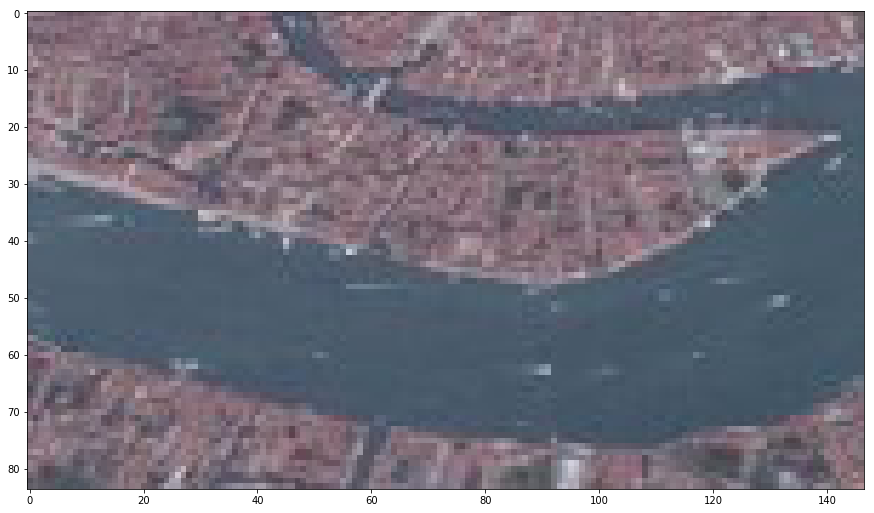

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(rgb)

# 1 - Image Segmentation

## Quickshift

In [13]:
from skimage.segmentation import quickshift, mark_boundaries


In [14]:
segments = quickshift(rgb, kernel_size=3, convert2lab=True, max_dist=3, ratio=0.3)

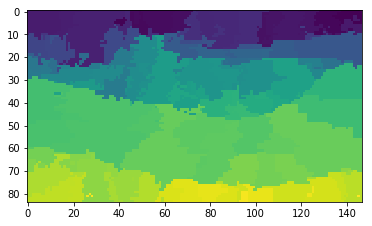

In [15]:
plt.imshow(segments)

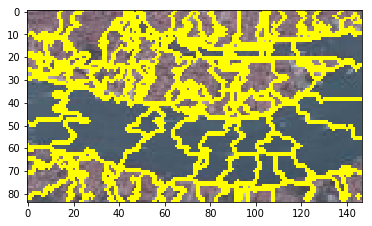

In [16]:
plt.imshow(mark_boundaries(rgb, segments))

In [56]:
from skimage.measure import regionprops
regions = regionprops(segments)

In [57]:
label_regions = [r.label for r in regions]

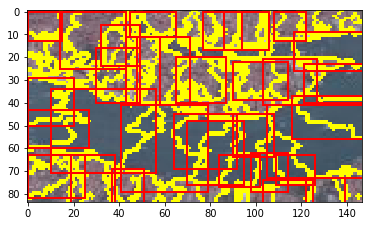

In [60]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(mark_boundaries(rgb, segments))

for region in regions:

    # skip small images
    if region.area < 121:
        continue

    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

## CIELAB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


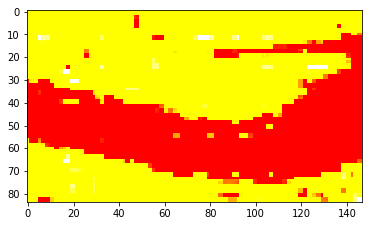

In [17]:
from skimage import color
lab = color.rgb2lab(rgb/255.0)
plt.imshow(lab)

(array([  45.,  227., 3644., 1106.,  681.,  873., 2308., 2705.,  601.,
         158.]), array([-16.34574106, -14.49887075, -12.65200043, -10.80513012,
         -8.95825981,  -7.11138949,  -5.26451918,  -3.41764887,
         -1.57077855,   0.27609176,   2.12296208]), <a list of 10 Patch objects>)

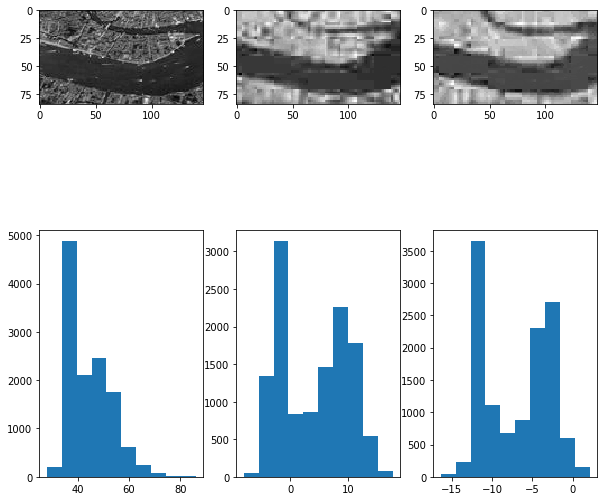

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(231)
plt.imshow(lab[:,:,0], cmap='gray')

plt.subplot(232)
plt.imshow(lab[:,:,1], cmap='gray')

plt.subplot(233)
plt.imshow(lab[:,:,2], cmap='gray')

plt.subplot(234)
plt.hist(list(lab[:,:,0].ravel()))

plt.subplot(235)
plt.hist(list(lab[:,:,1].ravel()))

plt.subplot(236)
plt.hist(list(lab[:,:,2].ravel()))


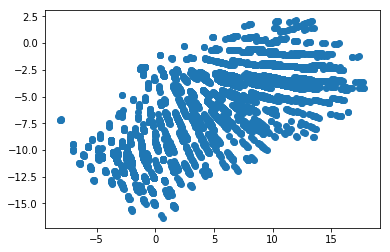

In [19]:
a_list = list(lab[:,:,1].ravel())
b_list = list(lab[:,:,2].ravel())
plt.scatter(a_list, b_list)

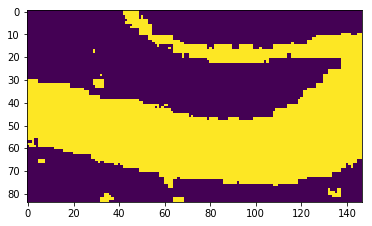

In [20]:
plt.imshow(lab[:,:,2] < -7.5)

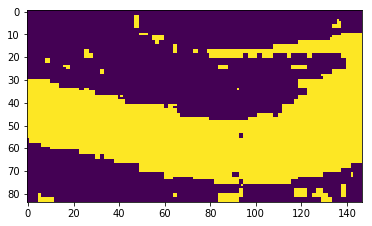

In [21]:
plt.imshow(lab[:,:,1] < 2)

In [22]:
!pip install plotly -q
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [23]:
from PIL import Image
pilImg = Image.fromarray(rgb, mode='RGB')
colorList = ['rgb'+str(x) for x in list(pilImg.getdata())]
L_rav = lab[:,:,0].ravel()
a_rav = lab[:,:,1].ravel()
b_rav = lab[:,:,2].ravel()

In [24]:
L_rav[0]

58.418128009484036

In [25]:
colorList = ['rgb'+str(x) for x in list(pilImg.getdata())]
colorList = [x.replace(' ', '') for x in colorList]
len(colorList)

12348

In [28]:
init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=lab[:,:,2].ravel(),
    y=lab[:,:,1].ravel(),
    z=lab[:,:,0].ravel(),
    mode='markers',
    marker=dict(
        size=5,
        color=lab[:,:,0].ravel(),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
config = {'linkText': "plot.ly"}
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale', config=config)

# Attempt #2 with GLCM

In [29]:
L = lab[:,:,0]

In [136]:
from skimage.feature import greycomatrix, greycoprops
PATCH_SIZE = 7
water_locations = [(45, 20), (50, 60), (45,120), (50,100)]
water_patches = []
for loc in water_locations:
    water_patches.append(L[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

In [137]:
land_locations = [(15, 25), (25, 60), (30,80), (70,20)]
land_patches = []
for loc in land_locations:
    land_patches.append(L[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

(-0.5, 146.5, 83.5, -0.5)

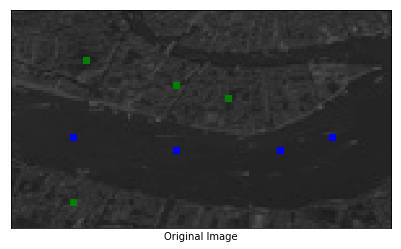

In [138]:
# create the figure
fig = plt.figure(figsize=(15, 15))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(L, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
for (y, x) in land_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

In [139]:
angles = [0*(np.pi/180), 45*(np.pi/180), 90*(np.pi/180), 135*(np.pi/180)]

In [140]:
L_u8 = L.astype(np.uint8)

In [141]:
# compute some GLCM properties each patch
xs = []
ys = []
asms_water = []
asms_land = []
for i, patch in enumerate(water_patches + land_patches):
    glcm = greycomatrix(patch.astype(np.uint8), [5], angles, 256, symmetric=True, normed=True)
    if i < 4:
        asms_water.append(greycoprops(glcm, 'ASM'))
    else:
        asms_land.append(greycoprops(glcm, 'ASM'))
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'ASM')[0, 0])

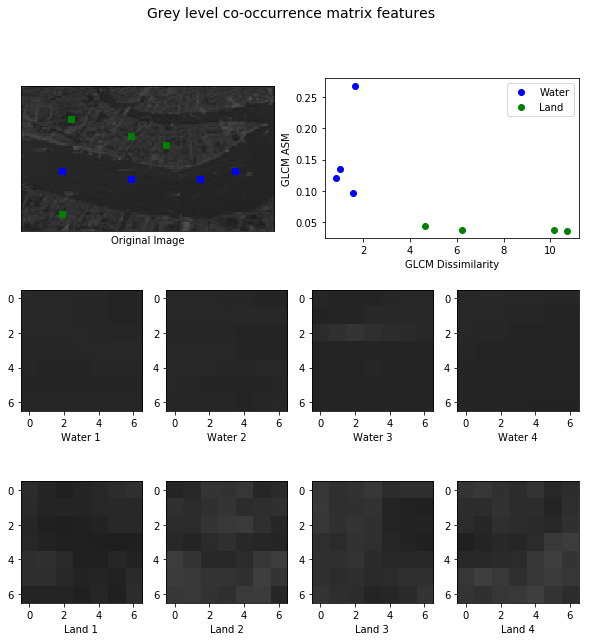

In [142]:
# create the figure
fig = plt.figure(figsize=(10, 10))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(L, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
for (y, x) in land_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(water_patches)], ys[:len(water_patches)], 'bo',
        label='Water')
ax.plot(xs[len(land_patches):], ys[len(land_patches):], 'go',
        label='Land')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM ASM')
ax.legend()

# display the image patches
for i, patch in enumerate(water_patches):
    ax = fig.add_subplot(3, len(water_patches), len(water_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Water %d' % (i + 1))

for i, patch in enumerate(land_patches):
    ax = fig.add_subplot(3, len(land_patches), len(land_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Land %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

## Feature Vector
FV = (ASM, Dissimilarity)

In [143]:
### get locations of segments
segment_locations = [tuple(list(map(int, r.centroid))) for r in regions]

In [144]:
segment_patches = []
for loc in segment_locations:
    segment_patches.append(L[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

In [145]:
asms_segment = []
xs = []
ys = []
for patch in segment_patches:
    glcm = greycomatrix(patch.astype(np.uint8), [5], angles, 256, symmetric=True, normed=True)
    ys.append(greycoprops(glcm, 'ASM')[0,0])
    xs.append(greycoprops(glcm, 'dissimilarity')[0,0])
    ary_glcm = np.append(greycoprops(glcm, 'ASM'), greycoprops(glcm, 'dissimilarity'))
    asms_segment.append(ary_glcm)

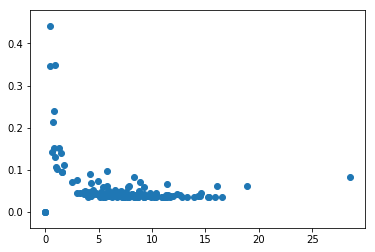

In [146]:
plt.scatter(xs, ys)

In [150]:
!pip install sklearn -q
from sklearn.cluster import DBSCAN

In [152]:
X_train = np.vstack(asms_segment)

In [233]:
dbscan = DBSCAN(eps=3, min_samples=3)

In [234]:
labels = dbscan.fit_predict(X_train)

In [235]:
[r.label for r in regions]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154]

In [236]:
label_map = {}
for i, r in enumerate(regions):
    label_map.update({r.label:labels[i]})
label_map

{1: 0,
 2: -1,
 3: -1,
 4: -1,
 5: 0,
 6: -1,
 7: -1,
 8: 0,
 9: 2,
 10: -1,
 11: -1,
 12: 0,
 13: 0,
 14: 0,
 15: -1,
 16: -1,
 17: 0,
 18: 0,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: -1,
 26: 0,
 27: -1,
 28: 0,
 29: 0,
 30: 1,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: -1,
 36: -1,
 37: 1,
 38: -1,
 39: 0,
 40: 0,
 41: 0,
 42: -1,
 43: -1,
 44: 0,
 45: -1,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 1,
 52: 0,
 53: -1,
 54: 0,
 55: 0,
 56: -1,
 57: 0,
 58: 1,
 59: -1,
 60: -1,
 61: 2,
 62: -1,
 63: -1,
 64: 0,
 65: 0,
 66: -1,
 67: 0,
 68: -1,
 69: 0,
 70: 0,
 71: -1,
 72: -1,
 73: -1,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 2,
 83: -1,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: -1,
 90: 0,
 91: 0,
 92: 1,
 93: -1,
 94: 0,
 95: 0,
 96: -1,
 97: 0,
 98: 0,
 99: 0,
 100: 3,
 101: 0,
 102: 0,
 103: -1,
 104: 0,
 105: -1,
 106: 3,
 107: 1,
 108: 3,
 109: -1,
 110: 3,
 111: 3,
 112: 3,
 113: 3,
 114: 0,
 115: 3,
 116: 0,
 117: 3,
 118: 3,
 119: 3,
 1

In [237]:
segments_relabel = np.zeros(segments.shape)
for i in range(segments.shape[0]):
    for j in range(segments.shape[1]):
        if segments[i, j] == 0:
            continue
        segments_relabel[i,j] = label_map[segments[i,j]] +2

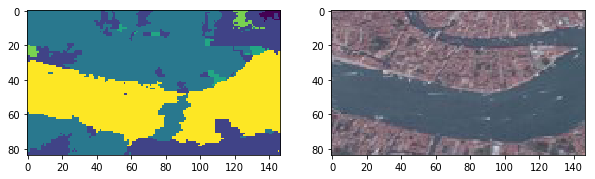

In [241]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(segments_relabel)

plt.subplot(122)
plt.imshow(rgb)